<a href="https://colab.research.google.com/github/vzinkovski/financial-data-science/blob/main/mean_reversion_pairs_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Commodities Mean Reversion Pairs Trading Strategy

*Last updated: 01 May 2023*

In its most simple form, all trading strategies can be classified as either momentum or mean reversion strategies. Commodities are often fungible, which means they can be used as substitutes for each other given the right economics. For such fungible commodities pairs this implies both a positive correlation, as well as cointegration. Cointegration simply means that the individual price series for the two commodities cannot deviate indefinitely and will revert to some mean value. This project will explore a mean reverting pairs trading strategy for a select universe of cointegrated agricultural commodities pairs. An inherent advantage of restricting our universe to commodities only is that these will be naturally free from survivorship bias. The continuous front month futures contract is used throughout.

### Import libraries

In [1]:
# standard libraries
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import time
from tqdm.notebook import tqdm # show progress bars

# financial analysis
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
import yfinance as yf # Yahoo! Finance API

# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

### USER INPUT: date range, benchmark, risk free rate, hyperparameters

Here the user must specify the date range from when to start applying the strategy. The date range is then split into a training (and validation) set, and test set. The user must also specify the number of days to be put aside for the test set.

Next the user may specify an initial commodities pair which to explore. After the initial exploration is complete, the user will then later on in this project have the opportunity to define a larger commodities pairs universe.

Next we specify the benchmark and risk free rate. This will allow us to measure our portfolio performance against a proxy, as well as calculate our Sharpe and Sortino ratios.

Finally, the user may choose an initial set of values for the hyperparameters of our strategy. These are parameters which are not learned by the model, but rather require a degree of user experience and judgement. In our strategy, explained in more detail later on, the main hyperparameters are lookback period, entry and exit thresholds, and stop loss margin.

A quick note regarding stop loss: there are arguments against adding stop losses in a mean reverting strategy. Instead, with increasing diversion there should be opportunity to scale in further if one believes that the pair should eventually revert to a mean value. However, as the saying goes, markets can stay irrational longer than one can stay solvent, hence a stop loss may prove prudent.

Lastly, we have bundled fees, commissions, slippage and market impact all into one variable, namely as a percentage cost of each trade. Needless to say, this is not reflective of the real world, but a quick and easy approximation that will suffice for this initial exploration of our strategy.

In [2]:
# date range for training set
start_train = '2007-01-01' # YYYY-MM-DD format
test_days = 1826 # get data up to 5 years ago (5*365.2425)
end_train = datetime.now() - timedelta(test_days)

# date range for test set
start_test = datetime.now() - timedelta(test_days-1)
end_test = datetime.now() - timedelta(1)

# benchmark
benchmark_name = 'S&P GSCI' # S&P GSCI
benchmark_ticker = 'GD=F'

# risk free rate
rfr_name = '3M US T-Bill' # 3-month US Treasury Bills
rfr_ticker = '^IRX'

# hyperparameters
lookback = 30 # rolling window for calculating mean and standard deviation
entry_threshold = 2 # Bollinger Bands +/- standard deviation width
exit_threshold = 1 # generate exit signal when mean reverting
stop_loss = 3 # generate exit signal when excessively mean diverting
leverage = 1 # amount of leverage to employ
fees = 0.015 # fees, commissions, slippage, market impact as a % of each transaction
stationarity_alpha = 0.1 # threshold for Augmented Dicky Fuller (ADF) stationarity test

# other
disable = True # suppress Yahoo! Finance and tqdm progress bars for final print

## Explore single commodities pair

### USER INPUT: single commodities pair

In [3]:
# commodities pair
product1_name = 'CME SRW'
product1_ticker = 'ZW=F'
product2_name = 'CME Corn'
product2_ticker = 'ZC=F'

### Fetch ticker data

In [4]:
def create_pairs_df(product1_name, product1_ticker, product2_name, product2_ticker, start, end):

  # fetch ticker data for one commodities pair as one GET request
  # Yahoo! Finance API rate limits are 60/minute, 360/hour, 8000/day
  pairs_df = yf.download([product1_ticker, product2_ticker],
                         start=start, end=end,
                         progress=(not disable))['Adj Close']
  cols = [product1_ticker, product2_ticker]
  pairs_df = pairs_df[cols]
  pairs_df.rename(columns={product1_ticker:product1_name, product2_ticker:product2_name}, inplace=True)
  pairs_df.fillna(method='ffill', inplace=True)
  
  return pairs_df

### Calculate spread

There are numerous ways to define a spread between a trading pair. However, for any mean reverting strategy the key is to ensure stationarity, which simply means a constant mean and variance for that spread.

In [5]:
def calculate_spread(pairs_df, lookback):

  # fit a rolling linear regression between the commodities pair
  model = RollingOLS(endog=pairs_df.iloc[:,0],
                     exog=sm.add_constant(pairs_df.iloc[:,1]),
                     window=lookback)
  rolling_res = model.fit()
  params = rolling_res.params.copy()

  # construct the hedge ratio
  pairs_df['hedge_ratio'] = params.iloc[:,1]
  pairs_df.dropna(inplace=True)

  # calculate the spread and ADF test statistic
  pairs_df['spread'] = pairs_df.iloc[:,0] - (pairs_df['hedge_ratio'] * pairs_df.iloc[:,1])
  adf_result = adfuller(pairs_df['spread'])
  pairs_df.dropna(inplace=True)

  return pairs_df, adf_result

### Test for stationarity

The most simple test for stationarity is a quick visual inspection through plotting the spread as a time series and checking for any presence of trend or heteroskedasticity. However, there are a number of more robust statistical approaches, such as the Phillips-Perron test, the Phillips-Ouliaris test, and the most commonly used Augmented Dicky-Fuller (ADF) test. All of these test for the presence of a unit root, the presence of which implies non-stationarity.

Normally, an $a$ value is predetermined in advance, after which the resulting p-value from any of these tests is compared against it. Should the p-value be less than the $a$ threshold, then we reject the null hypothesis and conclude that we have reason to believe that our data is indeed stationary.

We perform the ADF test on our initial exploratory commodities pair and obtain the results. The more negative the ADF statistic, the more strongly stationary our spread is and thus more suitable for a mean reverting strategy.

All these tests are sensitive to the time period specified and may conclude non-stationarity during periods within the overall timeframe. However, we have strong conviction that the cointegration between our commodities pairs is unlikely to break down due to regime change over the long run given their underlying fundamental factors.

In [6]:
def test_stationarity(pairs_df, adf_result, stationarity_alpha):
    
    # perform ADF test to check for stationarity
    if adf_result[1] < stationarity_alpha:
      return (pairs_df, adf_result, True)
    else:
      return (pairs_df, adf_result, False)

In [7]:
# run functions
pairs_df = create_pairs_df(product1_name, product1_ticker, product2_name, product2_ticker, start_train, end_train)
pairs_df, adf_result = calculate_spread(pairs_df, lookback)
pairs_df, adf_result, check = test_stationarity(pairs_df, adf_result, stationarity_alpha)

In [8]:
# print ADF test statistics
print('ADF statistic:\n%f' % adf_result[0], '\n')
print('p-value: \n%f' % adf_result[1], '\n')
print('Critical values:')
for key, value in adf_result[4].items():
  print('%s @ %.3f' % (key, value))

ADF statistic:
-8.317272 

p-value: 
0.000000 

Critical values:
1% @ -3.433
5% @ -2.863
10% @ -2.567


### Calculate Bollinger Bands

A mean reverting strategy will typically monitor the deviation of the spread from its rolling mean and standard deviation. The most well-known examples use Bollinger Bands or a Z-score. Our strategy uses Bollinger Bands as its base and defines additional bands to determine stop loss levels.

In [9]:
def calculate_bbands(pairs_df, lookback, entry_threshold, exit_threshold, stop_loss):

  # calculate the rolling mean and rolling std
  # we are using a SMA, but other options include a EMA, WMA or EWMA
  pairs_df['mean'] = pairs_df['spread'].rolling(window=lookback).mean()
  pairs_df['std'] = pairs_df['spread'].rolling(window=lookback).std()

  # calculate the rolling entry and exit bands, and rolling stop loss bands
  pairs_df['upper_entry'] = pairs_df['mean'] + entry_threshold * pairs_df['std']
  pairs_df['lower_entry'] = pairs_df['mean'] - entry_threshold * pairs_df['std']
  pairs_df['upper_exit'] = pairs_df['mean'] + exit_threshold * pairs_df['std']
  pairs_df['lower_exit'] = pairs_df['mean'] - exit_threshold * pairs_df['std']
  pairs_df['upper_stop_loss'] = pairs_df['mean'] + stop_loss * pairs_df['std']
  pairs_df['lower_stop_loss'] = pairs_df['mean'] - stop_loss * pairs_df['std']

  return pairs_df

### Define trading rules and get signal

Most Bollinger Bands and Z-score strategies define the entry signal as when the spread diverges $n$ standard deviations away from the rolling mean. We believe this is susceptible to extreme volatility events and as such prefer an entry signal when the spread begins reverting back towards the mean. In practice, this results not getting in at the top or bottom, but conversely achieving a higher win rate on trades entered. We short the spread on a downside crossover of the upper threshold, and go long the spread on an upside crossover of the lower threshold.

In [10]:
def get_trading_signals(pairs_df):

  # create signal column {-1, 0, 1}
  pairs_df['signal'] = 0

  # iterating through the time series to determine whether to buy/hold/sell
  # cannot be vectorised as today's trading signal depends on yday's signal
  # as such time complexity will be linear O(N)
  for i in range(1, len(pairs_df)):

    # from hold to sell or buy
    if pairs_df.iloc[i-1, -1] == 0:
      if (pairs_df['spread'][i] < pairs_df['upper_entry'][i]) & \
         (pairs_df['spread'][i-1] >= pairs_df['upper_entry'][i-1]):
        pairs_df.iloc[i, -1] = -1
      elif (pairs_df['spread'][i] > pairs_df['lower_entry'][i]) & \
           (pairs_df['spread'][i-1] <= pairs_df['lower_entry'][i-1]):
        pairs_df.iloc[i, -1] = 1

    # from sell to hold
    elif pairs_df.iloc[i-1, -1] == -1:
      if (pairs_df['spread'][i] < pairs_df['upper_exit'][i]) & \
         (pairs_df['spread'][i-1] >= pairs_df['upper_exit'][i-1]):
        pairs_df.iloc[i, -1] = 0
      # trigger stop loss on excessive mean diversion to the upside
      elif (pairs_df['spread'][i] > pairs_df['upper_stop_loss'][i]) & \
           (pairs_df['spread'][i-1] <= pairs_df['upper_stop_loss'][i-1]):
        pairs_df.iloc[i, -1] = 0
      else:
        pairs_df.iloc[i, -1] = -1

    # from sell to hold
    elif pairs_df.iloc[i-1, -1] == 1:
      if (pairs_df['spread'][i] > pairs_df['lower_exit'][i]) & \
         (pairs_df['spread'][i-1] <= pairs_df['lower_exit'][i-1]):
        pairs_df.iloc[i, -1] = 0
      # trigger stop loss on excessive mean diversion to the downside
      elif (pairs_df['spread'][i] < pairs_df['lower_stop_loss'][i]) & \
           (pairs_df['spread'][i-1] >= pairs_df['lower_stop_loss'][i-1]):
        pairs_df.iloc[i, -1] = 0
      else:
        pairs_df.iloc[i, -1] = 1

  return pairs_df

In [11]:
# run functions
pairs_df = calculate_bbands(pairs_df, lookback, entry_threshold, exit_threshold, stop_loss)
pairs_df = get_trading_signals(pairs_df)

### Plot commodities pair prices vs. trading signal

Continuing our exploration of the initially chosen single commodities pair we can visually inspect whether our signal is working as intended, and whether the timing of entry and exit seem reasonable.

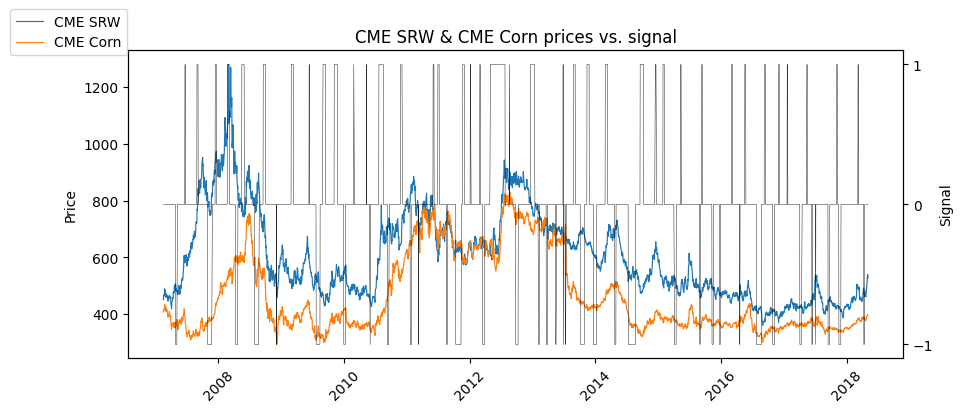

In [12]:
# plot bollinger bands & signal
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

ax1.plot(pairs_df.index, pairs_df.iloc[:,0], label=pairs_df.columns[0], linewidth=0.85)
ax1.plot(pairs_df.index, pairs_df.iloc[:,1], label=pairs_df.columns[1], linewidth=0.85)
ax1.set_ylabel('Price')
ax1.tick_params(axis='x', rotation=45)

ax2.plot(pairs_df.index, pairs_df['signal'], color='k', linewidth=0.3)
ax2.set_ylabel('Signal')
ax2.set_yticks([-1,0,1])

plt.title(f'{product1_name} & {product2_name} prices vs. signal')
fig.legend(bbox_to_anchor=(0, 1), loc="upper left")
plt.show();

### Get equity curve

In [13]:
def get_equity_curve(pairs_df, product1_name, product2_name, leverage, fees):

  pairs_df[f'{product1_name}_returns'] = pairs_df[product1_name].pct_change()
  pairs_df[f'{product2_name}_returns'] = pairs_df[product2_name].pct_change()
  
  # add leverage and fees
  # fees are typically added upstream resulting in net returns
  pairs_df['pair_daily_returns'] = pairs_df['signal'].shift() * leverage * (1-fees) * \
                                  (pairs_df[f'{product1_name}_returns'] - pairs_df[f'{product2_name}_returns'])
  pairs_df['pair_cumulative_returns'] = (1 + pairs_df['pair_daily_returns']).cumprod()

  return pairs_df

### Plot equity curve

The equity curve gives us a solid visual summary of our strategy performance over time. The base starting point is 100% and each time step $t$ is the percentage change from $t_{-1}$.

In [14]:
# run functions
pairs_df = get_equity_curve(pairs_df, product1_name, product2_name, leverage, fees)

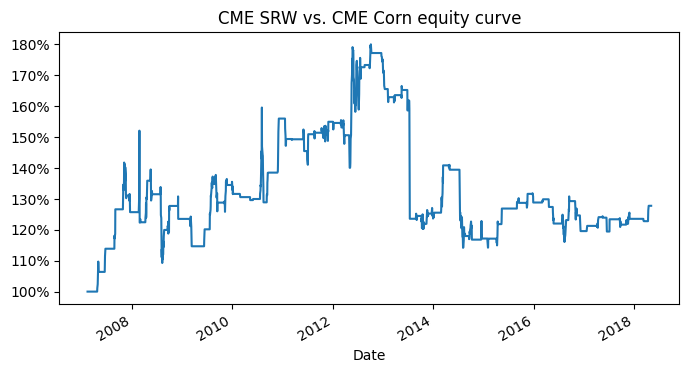

In [15]:
# plot equity curve
fig, ax = plt.subplots(figsize=(8, 4))
plt.title(f'{product1_name} vs. {product2_name} equity curve')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
pairs_df['pair_cumulative_returns'].plot();

## Explore commodities pairs universe

### USER INPUT: commodities pairs universe

Now that we have explored a single commodities pair it is time to expand our pairs universe. For completeness, it probably goes without saying that we need not limit ourselves to commodities only. Any pair which has a strong fundamental reason for being cointegrated may be considered. Often these will be pairs from the same sector, such as Apple and Microsoft, for example.

We have composed a universe of agricultural commodities. These are a fairly obvious choice for cointegration because when the prices of two fungible commodities diverge excessively, there will be demand destruction in the form of consumers shifting to close substitutes and rationing, as well as new supply becoming available in the form of farmer plantings and stock drawdowns. All of which serve to revert prices back to some mean value. Note, however, that this mean value is dynamic in its own right, and why finding a successful mean reverting strategy is no trivial undertaking.

Lastly, expanding our pairs universe we reap the benefit of diversification, which generally leads to less volatile returns and smaller drawdowns.

We have restricted our universe to a just few ags commodities pairs, as well as those listed on the CME only. This is mostly because this project is for illustrative purposes and also to speed up compute time.

In [16]:
pairs_universe = [
            
  # AGRICULTURE

            # srw corn
            {'product1_name':'srw', 
             'product1_ticker':'ZW=F',
             'product2_name':'corn',
             'product2_ticker':'ZC=F'
             },

            # hrw corn
            {'product1_name':'hrw', 
             'product1_ticker':'KE=F',
             'product2_name':'corn',
             'product2_ticker':'ZC=F'
             },

            # srw hrw
            {'product1_name':'srw', 
             'product1_ticker':'ZW=F',
             'product2_name':'hrw',
             'product2_ticker':'KE=F'
             },

            # soymeal soybeans
            {'product1_name':'soymeal', 
             'product1_ticker':'ZM=F',
             'product2_name':'soybeans',
             'product2_ticker':'ZS=F'
             },

            # soyoil soybeans
            {'product1_name':'soyoil', 
             'product1_ticker':'ZL=F',
             'product2_name':'soybeans',
             'product2_ticker':'ZS=F'
             },

            # soymeal soyoil
            {'product1_name':'soymeal', 
             'product1_ticker':'ZM=F',
             'product2_name':'soyoil',
             'product2_ticker':'ZL=F'
             },

            # corn sugar
            {'product1_name':'corn', 
             'product1_ticker':'ZC=F',
             'product2_name':'sugar',
             'product2_ticker':'SB=F'
             },

]

### Get portfolio returns

For now we assume an equally weighted cash allocation for each commodities pair. In order to further optimise a portfolio, rebalancing would need to be considered. Common rebalancing approaches are volatility-weighted (aka risk parity) and percentage-of-portfolio.

In [17]:
def get_portfolio_returns(pairs_universe, start, end, lookback, entry_threshold, exit_threshold, stop_loss):

  # create empty list of dataframes
  dfs = []
  columns = []
  total_trades = 0

  # loop through all pairs in universe
  for pair in pairs_universe:

    # check if commodities pair has optimised hyperparameters
    if isinstance(pair, tuple):
      # convenience variables
      product1_name = pair[0]['product1_name']
      product1_ticker = pair[0]['product1_ticker']
      product2_name = pair[0]['product2_name']
      product2_ticker = pair[0]['product2_ticker']
      # optimal hyperparameters found in training set
      _, lookback, entry_threshold, exit_threshold, stop_loss = pair[1]
    else:
      # convenience variables
      product1_name = pair['product1_name']
      product1_ticker = pair['product1_ticker']
      product2_name = pair['product2_name']
      product2_ticker = pair['product2_ticker']

    # run functions
    pairs_df = create_pairs_df(product1_name, product1_ticker, product2_name, product2_ticker, start, end)
    pairs_df, adf_result = calculate_spread(pairs_df, lookback)
    pairs_df, adf_result, check = test_stationarity(pairs_df, adf_result, stationarity_alpha)

    # proceed only for stationary time series
    if check:

      # run functions
      pairs_df = calculate_bbands(pairs_df, lookback, entry_threshold, exit_threshold, stop_loss)
      pairs_df = get_trading_signals(pairs_df)
      pairs_df = get_equity_curve(pairs_df, product1_name, product2_name, leverage, fees)

      # append returns for each pair to dataframe
      pairs_df['pair_cumulative_returns'].fillna(method='ffill', inplace=True)
      dfs.append(pairs_df['pair_cumulative_returns'])
      columns.append(f'{product1_name}_{product2_name}')

      # calculate number of trades
      pairs_df['temp'] = pairs_df['signal'].shift()
      pairs_df['trade_count'] = pairs_df['signal'] != pairs_df['temp']
      del pairs_df['temp']
      total_trades += pairs_df['trade_count'].sum() * 2 # one trade per leg

  # create dataframe from list and calculate mean returns
  pairs_universe_df = pd.DataFrame(dfs).T
  pairs_universe_df.columns = columns
  pairs_universe_df.fillna(method='ffill', inplace=True)
  pairs_universe_df['portfolio_cumulative_returns'] = pairs_universe_df.mean(axis=1)

  return pairs_universe_df, total_trades

In [18]:
# run functions
pairs_universe_df_train, total_trades = get_portfolio_returns(pairs_universe, start_train, end_train,
                                                              lookback, entry_threshold, exit_threshold, stop_loss)

### Get benchmark returns

How do we judge whether our portfolio returns are satisfactory? In order to do so, we usually compare our returns against those of a benchmark. Of course we seek to achieve positive returns, but if our positive returns are less than those of its benchmark, our strategy cannot be considered as successful. If our strategy achieves negative returns (ideally not), but does in fact manage to outperform its benchmark, such a result may still be considered acceptable.

Another option is to compare our returns against a risk-free-rate, which will be discussed further down.

Note: Because our strategy is a long-short strategy it is dollar-neutral and thus self-financing. Therefore, some literature suggests that comparing it to an index is not-appropriate, given indexes are typically reflective of a long-only buy-and-hold strategy. Conversely, other literature and many large institutional long-short investors do in fact state the usefulness of comparing versus a benchmark. We side with the latter.

In [19]:
def get_benchmark_returns(benchmark_ticker, start, end):

  # get benchmark returns
  bm_df = yf.download([benchmark_ticker], start=start, end=end, progress=(not disable))
  bm_df.fillna(method='ffill', inplace=True)
  bm_df[f'{benchmark_name}_daily_returns'] = bm_df['Adj Close'].pct_change()
  bm_df[f'{benchmark_name}_cumulative_returns'] = (1 + bm_df[f'{benchmark_name}_daily_returns']).cumprod()

  return bm_df

In [20]:
# run functions
bm_df = get_benchmark_returns(benchmark_ticker, start_train, end_train)

### Plot portfolio and benchmark returns for training set

Here we take a look at the aggregated equity curve of our commodity pairs universe compared against the S&P GSCI.

We perform this comparison strictly over the training data only.

In [21]:
def plot_portfolio_vs_benchmark_returns(pairs_universe_df, bm_df, benchmark_name):

  # plot portfolio and benchmark returns
  fig, ax = plt.subplots(figsize=(8, 4))

  for col in pairs_universe_df.columns[:-1]:
    ax.plot(pairs_universe_df.index, pairs_universe_df[col], color='gray', linewidth=0.5, linestyle='--')
    
  ax.plot(pairs_universe_df.index, pairs_universe_df['portfolio_cumulative_returns'],
          color='b', linewidth=1, label='portfolio')
  ax.plot(bm_df.index, bm_df[f'{benchmark_name}_cumulative_returns'],
          color='r', linewidth=1, label=f'{benchmark_name}')
  ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
  plt.title(f'Portfolio vs. {benchmark_name} returns')
  plt.legend()

  return plt.show()

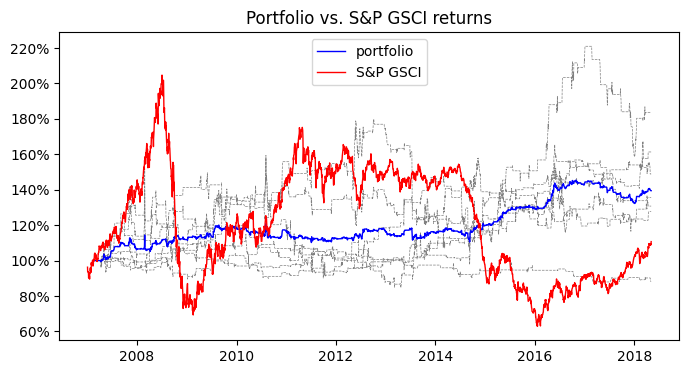

In [22]:
# run functions
plot_portfolio_vs_benchmark_returns(pairs_universe_df_train, bm_df, benchmark_name)

### Get risk free rate

Worth keeping in mind is that most investments inherently carry an opportunity cost of capital. That is to say that only portfolio returns in excess of the risk-free-rate should be considered. A widely used measure for the risk-free-rate is the 3-month (aka 13-week) U.S. Treasury Bill, deemed a liquid and (almost) riskless investment.

The concept of excess returns is important, and again there are differing schools of thought with regards to how this applies to a market-neutral portfolio. Given such a portfolio is self-financing, there in fact should not be an opportunity cost of capital. Nevertheless, we take a conservative approach and factor in the risk-free-rate by subtracting it from our portfolio returns.

In summary, we use the benchmark as a visual marker to compare our portfolio against, and we use the risk-free-rate to calculate our Sharpe and Sortino ratios. From our own research, it was difficult to establish a consensus on what approach is the 'correct' one and we happily welcome any feedback you may have in this respect. Please let us know your thoughts by contacting me through any of the links at the bottom of this article.

In [23]:
def get_risk_free_rate(rfr_ticker, start, end):

  # get risk free rate
  rfr_df = yf.download([rfr_ticker], start=start, end=end, progress=(not disable))
  rfr_df['daily_risk_free_rate'] = rfr_df['Adj Close'] / 100 / 252 # division in order to annualise the rate
  rfr_df.fillna(method='ffill', inplace=True)

  return rfr_df

In [24]:
# run functions
rfr_df = get_risk_free_rate(rfr_ticker, start_train, end_train)

### Get universe performance metrics for training set

Whilst the equity curve is informative, it is unable to provide us with one number summary statistics. Such statistics allow for effective side-by-side comparison of different trading strategies, as well as compare performance of the same strategy over different periods of time.

The de facto gold-standard performance metric is considered to be the Sharpe ratio, which is a measure of risk adjusted returns. Others prefer to use the Sortino ratio instead, which is a similar calculation, except that it does not penalise upside volatility of returns.

Other common metrics are CAGR, maximum drawdown percentage, maximum drawdown duration (often in days), R-squared, winning trades percentage, win/loss ratio, as well as portfolio alpha and beta. Alpha is the excess return of a portfolio compared to its benchmark. Beta refers to the measure of a portfolio's volatility in relation to the benchmark. A dollar-neutral long-short strategy, such as ours, will by definition be expected to have a beta close to zero.

We first calculate these performance metrics strictly over the training set only. It is of crucial importance that we keep aside an unseen test set in order to avoid lookahead bias. Once we are satisfied with our strategy results over the training set, then we are allowed one final inspection of our strategy and its performance over the test set. No adjustments to the strategy are allowed after this final holdout set has been used.

In [25]:
def get_universe_performance_metrics(pairs_universe_df, bm_df, rfr_df):

  # calculate total returns
  total_returns = (pairs_universe_df["portfolio_cumulative_returns"][-1] * 100) - 100

  # calculate annualised returns
  days = len(pairs_universe_df)
  annualised_returns = (pairs_universe_df["portfolio_cumulative_returns"][-1] ** (252/days) -1) * 100

  # calculate returns in excess of risk free rate
  pairs_universe_df['portfolio_daily_returns'] = pairs_universe_df['portfolio_cumulative_returns'].diff()
  pairs_universe_df['daily_risk_free_rate'] = rfr_df['daily_risk_free_rate']
  pairs_universe_df['excess_returns'] = pairs_universe_df['portfolio_daily_returns'] - pairs_universe_df['daily_risk_free_rate']
  pairs_universe_df.dropna(inplace=True)

  # calculate annualised volatility
  annualised_volatility = np.std(pairs_universe_df['portfolio_daily_returns']) * (252**0.5) * 100

  # calculate sharpe ratio
  sharpe_ratio = pairs_universe_df['excess_returns'].mean() / pairs_universe_df['excess_returns'].std()
  sharpe_ratio_annualised = sharpe_ratio * np.sqrt(252)

  # calculate sortino ratio
  downside_returns = pairs_universe_df['excess_returns'][pairs_universe_df['excess_returns'] < 0]
  downside_deviation = downside_returns.std()
  sortino_ratio = pairs_universe_df['excess_returns'].mean() / downside_deviation
  sortino_ratio_annualised = sortino_ratio * np.sqrt(252)

  # calculate max drawdown % from peak to trough
  rolling_max = pairs_universe_df['portfolio_cumulative_returns'].expanding().max()
  drawdown = pairs_universe_df['portfolio_cumulative_returns'] - rolling_max
  max_drawdown = (drawdown / rolling_max).min() * 100

  # calulate portolfio alpha and beta vs. benchmark
  temp_df = pd.concat([pairs_universe_df['portfolio_daily_returns'],
                       bm_df[f'{benchmark_name}_daily_returns']],
                      axis=1).dropna()
  X = sm.add_constant(temp_df.iloc[:,1])
  model = sm.OLS(temp_df.iloc[:,0], X).fit()
  portfolio_alpha, portfolio_beta = model.params

  # print performance metrics
  print(f'Total returns: \t\t\t {round(total_returns, 2)}%')
  print(f'Annualised returns: \t\t {round(annualised_returns, 2)}%')
  print(f'Annualised volatility: \t\t {round(annualised_volatility, 2)}%')
  print(f'Sharpe ratio (annualised): \t {round(sharpe_ratio_annualised, 2)}')
  print(f'Sortino ratio (annualised): \t {round(sortino_ratio_annualised, 2)}')
  print(f'Maximum drawdown: \t\t {round(max_drawdown, 2)}%')
  print(f'Beta vs. {benchmark_name}: \t\t {round(portfolio_beta, 4)}')
  print(f'Total # of trades: \t\t {total_trades}')

  return None

In [26]:
# run functions
get_universe_performance_metrics(pairs_universe_df_train, bm_df, rfr_df)

Total returns: 			 39.47%
Annualised returns: 		 3.01%
Annualised volatility: 		 6.7%
Sharpe ratio (annualised): 	 0.43
Sortino ratio (annualised): 	 0.54
Maximum drawdown: 		 -9.06%
Beta vs. S&P GSCI: 		 -0.0003
Total # of trades: 		 2098


## Optimise strategy using training set

### USER INPUT: hyperparameter search space

We first divide our training set into folds -- in our case we have chosen one-year folds. Next we define a set of hyperparameters over which to perform an exhaustive grid search. We then iterate over each fold in a walk-forward fashion, applying every possible combination of hyperparameters and each time calculating the Sharpe ratio achieved. For each fold, the hyperparameters which maximise the Sharpe ratio are saved. Finally, the optimal sets of hyperparameters are averaged in an ensemble approach. The idea is that this final averaged combination of hyperparameters will prove robust and generalise to our test set.

This process is repeated for each commodities pair in the universe.

Note: The way our code is written is a series of nested for loops. In reality, a lot of the operations can be parallelised as each commodity pair and fold can computed concurrently, and their results aggregated at the end.

In [27]:
# hyperparameter search space
lookbacks = [30, 45, 60]
entries = [1.8, 2.0, 2.2, 2.4]
exits = [0, 0.5, 1.0, 1.5]
stops = [2.5, 3.5]

### Get pairs Sharpe ratio

The Sharpe ratio is the most widely used single metric for comparing portfolio performance apples-to-apples. Therefore, when optimising our strategy, this is the metric we will seek to maximise.

In [28]:
def get_pairs_sharpe_ratio(pairs_df, rfr_df):

  # calculate returns in excess of risk free rate
  pairs_df['daily_risk_free_rate'] = rfr_df['daily_risk_free_rate']
  pairs_df['excess_returns'] = pairs_df['pair_daily_returns'] - pairs_df['daily_risk_free_rate']

  # calculate sharpe ratio
  sharpe_ratio = pairs_df['excess_returns'].mean() / pairs_df['excess_returns'].std()
  sharpe_ratio_annualised = sharpe_ratio * np.sqrt(252)

  return sharpe_ratio_annualised

### Optimise hyperparameters over training set

This section performs a walk-forward hyperparameter optimisation. Our model does not have any learnable parameters, but should this have been the case then this following block of code would have incorporated a cross-validation approach.

In [29]:
def optimise_hyperparameters(pairs_universe, start, end):

  # divide training date range into successive subsets preserving temporal order
  def get_annual_indexes(df):
    n_splits = int(len(df) / 252)
    indexes = []
    for i in range(n_splits):
      indexes.append(df.index[((i) * 252):((i+1) * 252)])
    return indexes
  indexes = get_annual_indexes(pairs_universe_df_train)

  # record sharpe ratios and hyperparameter combo for each commodities pair
  hyperparameter_results = []

  # test all hyperparameter combinations for each commodities pair
  for pair in tqdm(pairs_universe, leave=False, disable=disable):

    # record sharpe ratio for each hyperparameter combo for single commodities pair
    sharpes = []

    # convenience variables
    product1_name = pair['product1_name']
    product1_ticker = pair['product1_ticker']
    product2_name = pair['product2_name']
    product2_ticker = pair['product2_ticker']

    # make dataframe copy to avoid repeatedly calling Yahoo! Finance API
    pairs_df_saved = create_pairs_df(product1_name, product1_ticker,
                                    product2_name, product2_ticker,
                                    start_train, end_train)

    # iterate over successive subsets of training data
    for index in tqdm(indexes, leave=False, disable=disable):

      # collect sharpe ratio for each successive walk forward with fixed hyperparameters
      combos = []

      # iterate over all possible hyperparameter combinations
      for lookback in tqdm(lookbacks, leave=False, disable=disable):
        for entry in tqdm(entries, leave=False, disable=disable):
          for exit in tqdm(exits, leave=False, disable=disable):
            for stop in tqdm(stops, leave=False, disable=disable):
              
              # convenience variables
              lookback = lookback
              entry_threshold = entry
              exit_threshold = exit
              stop_loss = stop

              # run functions
              pairs_df = pairs_df_saved.copy()
              pairs_df = pairs_df.loc[index]
              pairs_df, adf_result = calculate_spread(pairs_df, lookback)
              pairs_df, adf_result, check = test_stationarity(pairs_df, adf_result, stationarity_alpha)
              pairs_df = calculate_bbands(pairs_df, lookback, entry_threshold, exit_threshold, stop_loss)
              pairs_df = get_trading_signals(pairs_df)
              pairs_df = get_equity_curve(pairs_df, product1_name, product2_name, leverage, fees)
              sharpe_ratio_annualised = get_pairs_sharpe_ratio(pairs_df, rfr_df)
              combos.append((sharpe_ratio_annualised, lookback, entry, exit, stop))

      # append optimal hyperparameters found on slice of training date range
      sharpes.append(max(combos, key=lambda x:x[0]))

    # combine optimal hyperparameters from all slices and take average
    dt = np.dtype('float32')
    arr = np.array(sharpes, dtype=dt)
    arr = np.mean(arr, axis=0)
    arr = list(arr)
    arr[1] = int(arr[1])
    hyperparameter_results.append((pair, arr))

  return hyperparameter_results

### Plot portfolio and benchmark returns for training set (with optimised hyperparameters)

Having obtained the optimal set of hyperparameters over the training set we would naturally expect our performance metrics for this same training set to improve. However, given we used successive time folds and then an averaging of our hyperparameters, we have in fact introduced a measure of bias into our strategy. Due to this bias we may expect to see decreased performance on the training set, but in return also hopefully less variance in the test set (i.e. better generalisability to unseen data).

This is known as the bias-variance trade-off. Usually discussed for models with learnable parameters, but with some relevance here as well.

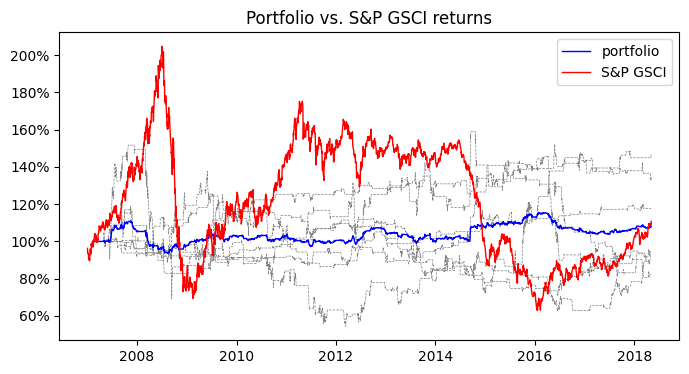

In [30]:
# run functions
pairs_universe_optimised = optimise_hyperparameters(pairs_universe, start_train, end_train)
pairs_universe_df, total_trades = get_portfolio_returns(pairs_universe_optimised, start_train, end_train,
                                                        lookback, entry_threshold, exit_threshold, stop_loss)
plot_portfolio_vs_benchmark_returns(pairs_universe_df, bm_df, benchmark_name)

### Get universe performance metrics for training set (with optimised hyperparameters)

In [31]:
# run functions
get_universe_performance_metrics(pairs_universe_df, bm_df, rfr_df)

Total returns: 			 8.1%
Annualised returns: 		 0.7%
Annualised volatility: 		 5.14%
Sharpe ratio (annualised): 	 0.01
Sortino ratio (annualised): 	 0.01
Maximum drawdown: 		 -15.62%
Beta vs. S&P GSCI: 		 0.0158
Total # of trades: 		 1602


## Evaluate strategy on test set

This is the part where is all comes together. Our ambition is to outperform the benchmark and achieve a satisfactory Sharpe ratio on the as-yet-unseen test data.

However, as with all trading strategies and forecasting models in general, past performance is no indication of future performance.

### Plot portfolio and benchmark returns for test set

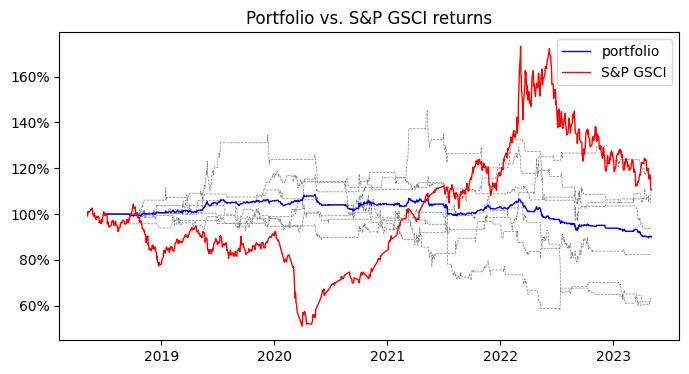

In [32]:
# run functions
pairs_universe_df, total_trades = get_portfolio_returns(pairs_universe_optimised, start_test, end_test,
                                                        lookback, entry_threshold, exit_threshold, stop_loss)
bm_df_test = get_benchmark_returns(benchmark_ticker, start_test, end_test)
plot_portfolio_vs_benchmark_returns(pairs_universe_df, bm_df_test, benchmark_name)

### Get universe performance metrics for test set

In [33]:
# run functions
rfr_df_test = get_risk_free_rate(rfr_ticker, start_test, end_test)
get_universe_performance_metrics(pairs_universe_df, bm_df_test, rfr_df_test)

Total returns: 			 -9.97%
Annualised returns: 		 -2.14%
Annualised volatility: 		 4.87%
Sharpe ratio (annualised): 	 -0.72
Sortino ratio (annualised): 	 -0.87
Maximum drawdown: 		 -17.45%
Beta vs. S&P GSCI: 		 0.0054
Total # of trades: 		 728


## Results

Unfortunately, our strategy failed to outperform its S&P GSCI benchmark over the test set, as well as seeing a reduced Share ratio versus the training set. 

A few possible reasons are:
- Our universe includes agricultural commodities only, whereas energy had a strong performance during the post COVID-19 pandemic recovery and another spike after Russia's invasion of Ukraine (although the latter was bullish for grains as well).
- Cointegration for some of our commodities pairs may have temporarily fallen apart during the strongly volatile market conditions caused by the aforementioned two factors.
- This is a very simple strategy, easily replicable and lacking any 'secret-sauce'. It is therefore not surprising that any potential alpha has been long arbitraged away.

## Conclusion

Unfortunately, our initial research phase does not suggest that this strategy is viable. As a rule of thumb, a Sharpe ratio between 1-2 would be considered decent and greater than 2 as good. It may be tempting to tweak our hyperparameters until we achieve such a result on our out-of-sample data, however this is strictly prohibited and would be a mistake known as optimisation bias (also called curve-fitting bias or data-snooping bias).

Also worth reiterating, once the hold-out data has been used, there is no going back. Various other fields of research suffer from a different, albeit related, problem where they will run experiments over and over again until achieving a statistically significant result (i.e. p-hacking).

Despite our strategy not achieving a satisfactory Sharpe ratio, we have deliberately chosen to report it as-is. Nevertheless, this project may serve as a launching point from which to explore our next trading idea. Also, most of our backtesting code can be reused with minimal modifications.

## Further investigation

Some ideas which may be worth exploring in order to further develop our strategy:

- Can the entry, exit and stop loss thresholds be adjusted dynamically, rather than being kept fixed? This could, for example, be accomplished by using a rolling standard deviation of the S&P GSCI, or incorporating other exogenous variables such as the VIX.
- Considering the total number of trades, this strategy would be considered low frequency. Generally speaking, higher frequency strategies, despite incurring higher transactions costs, produce higher Sharpe ratios. Our strategy is beginner friendly in the sense that, given a reasonably sized universe, can probably be executed manually. We could look to increase trading frequency through incorporating an EMA, WMA or EWMA, or by lowering our entry thresholds (with the result of having smaller, but more frequent, winning trades).
- Mean reverting strategies typically underperform in trending markets. As such, this strategy would benefit by combining it with a momentum strategy. The net result would likely be a partial offset, thus achieving lower total returns, but conversely also a reduced volatility, thus hopefully leading to a higher Sharpe ratio.
- Alternatively, we may choose to switch off or scale down this strategy during strongly trending periods. This may be achieved by overlaying the model with an indicator (e.g. ADX or more sophisticated ML classification model) which gives us a probability of being in either a sideways or trending environment.
- As mentioned in passing earlier, this strategy has an equally weighted allocation among all commodities pairs and would undoubtedly benefit from more sophisticated allocation methods.
- Scaling in and out of positions is likely to improve performance. This may be achieved through stacking different lookback periods, and entry and exit levels.

# END

**Author: Vladimir Zinkovski**

Send an email: *vladimir.zinkovski@gmail*

Or connect with me on: [LinkedIn](https://www.linkedin.com/in/vladimir-zinkovski/)